## Laser Heating Inclusion in Plasma Decay

In [2]:
import sys
import os
dir = os.path.dirname(r".\PLPAK")
sys.path.append(dir)


import PLPAK as pl
print("PLPAK version: ", pl.__version__)

PLPAK version:  0.1.0


## Add the laser heating model to existing plasmaSystems class.

Here, use the same plasmaSystems class and based on it extend the dTdt_ method to include laser heating. The new model will be derived from the existing model of N2plasma.

In [ ]:
# From the library, use one of the plasmaSystems to create a new derived class

# The class to base the new class on
baseClass = pl.plasmaSystems.N2Plasma_54Rxn # can change this to any of the plasmaSystems when needed

# make the new class, only need to change the dTdt_ method.
class N2Plasma_54Rxn_Heating(baseClass):

    # instantiate the class
    def __init__(self, Ysp, T, verbose = False, **kwargs):
        # new variables from **kwargs
        

In [1]:
kB = 1.38064852e-23 # J/K


Ntot = 2.45e25 # m^-3
T = 300 # K

del_T = 500 # K

new_T = T + del_T
new_p = Ntot * kB * new_T

print("new_p: ", new_p)
print("new_T: ", new_T)


new_p:  270607.10992
new_T:  800


## $O_2-O$ vibrational relaxation

Ref: 
https://deepblue.lib.umich.edu/bitstream/handle/2027.42/140531/6.2015-3251.pdf?sequence=1

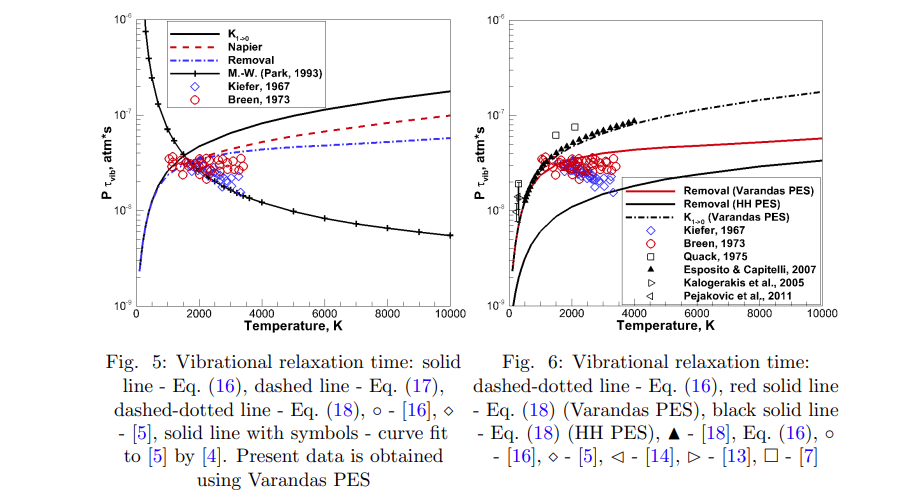

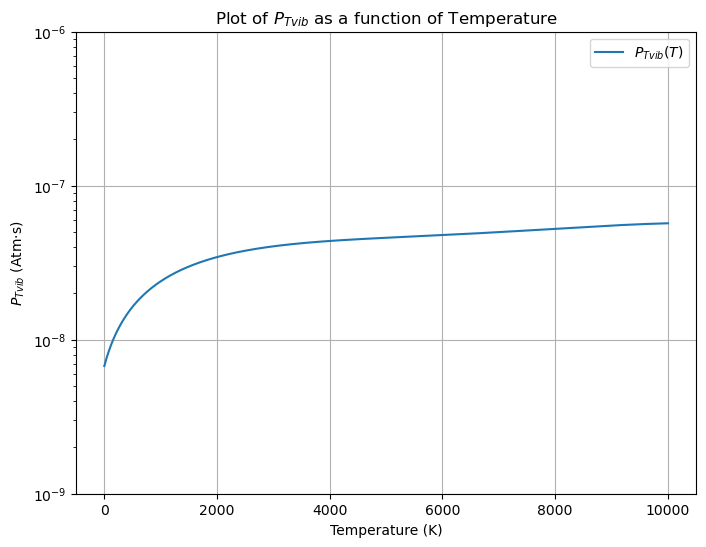

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the coefficients from the equation in the image
a = -0.001798
b = 0.04853
c = -0.4695
d = 2.143
e = 0.673

# Define the function from the equation
def P_Tvib(T):
    x = T / 1000
    return (a*x**4 + b*x**3 + c*x**2 + d*x + e) * 1e-8

# Generate temperature values in Kelvin
T_values = np.linspace(1, 10000, 500)  # T in K

# Calculate the corresponding P_Tvib values
P_values = P_Tvib(T_values)

# Plot the function
plt.figure(figsize=(8,6))
plt.plot(T_values, P_values, label=r'$P_{Tvib}(T)$')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$P_{Tvib}$ (Atm·s)')
plt.title(r'Plot of $P_{Tvib}$ as a function of Temperature')

plt.yscale('log')
# limit y
plt.ylim(1e-9, 1e-6)

plt.grid(True)
plt.legend()
plt.show()


Fitted parameters: a=-0.005798969725915833, b=0.11728071482076785, c=-0.8698505755385431, d=3.057577147662221, e=-0.043170994873928975


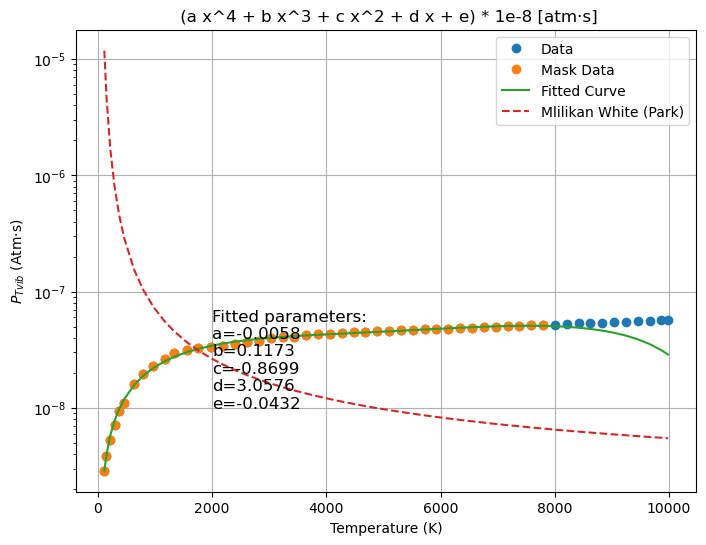

In [133]:
## use this expession to fit to given data:
'''
# Define the function from the equation
def P_Tvib(T):
    x = T / 1000
    return (a*x**4 + b*x**3 + c*x**2 + d*x + e) * 1e-8
'''
## Data ../plasmaKinetics/o2-ovibrationalCollisions.csv, tab delimited



## another represnetation of the relaxation time in atm-s is using the milikan white expression, modified 
# np.exp(A*(Tv**(-1.0/3.0) - B) - 18.42)
# https://link.springer.com/content/pdf/10.1007/s00193-012-0401-z.pdf
def MW_park(Tv, A, B):
    return np.exp(A * (Tv ** (-1.0 / 3.0) - B) - 18.42) #[atm*s]

o2_o_MW_MOD_ABs = [47.7,0.0590]



import numpy as np
import scipy.optimize as opt

# Load the data from the CSV file, use pandas
data = np.loadtxt("../../../plasmaKinetics/o2-ovibrationalCollisions.txt", delimiter='\t')

# import pandas as pd
# data = pd.read_csv("../../../plasmaKinetics/o2-ovibrationalCollisions.csv", delimiter='\t', header=None).values

temp = data[:, 0]  # Temperature values
p_tau = data[:, 1]  # P_Tvib values





# Fit the data to the fitfunction
def  fit_function(T, a, b, c, d, e):
    # x = T / 100
    # return (a*x**4 + b*x**3 + c*x**2 + d*x + e) * 1e-8
    # return (a*np.exp(b*x)*(c*x**2 + d*x + e) * 1e-8 )
    x = T/1000
    # return ( a*np.log(x) + b*np.log(x)**2 + c*np.log(x)**3 + d*np.log(x)**4 + e )
    # y=exp(A+B*ln(x)+C/x+D/x^2+E/x^3)
    # return (np.exp(a + c/x + d/x**2 + e/x**3)*np.tanh(b*x)) 
    return (a*x**4 + b*x**3 + c*x**2 + d*x + e) * 1e-8

# Fitted parameters: a=-0.005798969725915833, b=0.11728071482076785, c=-0.8698505755385431, d=3.057577147662221, e=-0.043170994873928975


ptau_VT_o2_o = lambda T: (-0.005798969725915833 * (T/1000)**4 + 
                        0.11728071482076785 * (T/1000)**3 + 
                        -0.8698505755385431 * (T/1000)**2 + 
                        3.057577147662221 * (T/1000) + 
                        -0.043170994873928975) * 1e-8


# fit from low - fit high temp only
fitHigh = 8000
mask = temp < fitHigh
popt, pcov = opt.curve_fit(fit_function, temp[mask], p_tau[mask])
# popt, pcov = opt.curve_fit(fit_function, temp, p_tau)

# Extract the fitted parameters
a_fit, b_fit, c_fit, d_fit, e_fit = popt

# Print the fitted parameters with expression and plt
print(f'Fitted parameters: a={a_fit}, b={b_fit}, c={c_fit}, d={d_fit}, e={e_fit}')



# Calculate the fitted P_Tvib values
P_fit = fit_function(temp, *popt)
# P_fit = ptau_VT_o2_o(temp) 

## calculate using MW_park
MW_fit = MW_park(temp, o2_o_MW_MOD_ABs[0], o2_o_MW_MOD_ABs[1])

# Plot the original data and the fitted curve
plt.figure(figsize=(8,6))
plt.plot(temp, p_tau, 'o', label='Data')
plt.plot(temp[mask], p_tau[mask], 'o', label='Mask Data')
plt.plot(temp, P_fit, '-', label='Fitted Curve')


# plot the MW fit
plt.plot(temp, MW_fit, '--', label='Mlilikan White (Park)')

plt.xlabel('Temperature (K)')
plt.ylabel(r'$P_{Tvib}$ (Atm·s)')
# (a*x**4 + b*x**3 + c*x**2 + d*x + e) * 1e-8
plt.title(r" (a x^4 + b x^3 + c x^2 + d x + e) * 1e-8 [atm·s]")

# show the fitted values in text
plt.text(2000, 1e-8, f'Fitted parameters:\na={a_fit:.4f}\nb={b_fit:.4f}\nc={c_fit:.4f}\nd={d_fit:.4f}\ne={e_fit:.4f}', fontsize=12)



plt.yscale('log')
# plt.ylim(1e-9, 1e-6)
plt.grid(True)
plt.legend()
plt.show()





### Energy Stored in vibrational excitation of $O_2$

The characteristic vibratioanl temeprautre of $O_2$ is $\theta_v = 2256 K$. The

$$E_{vib} = \frac{n_v \theta_v}{exp(\theta_v/T) - 1}$$

where $n_v$ is the number density of the oxygen molecules.




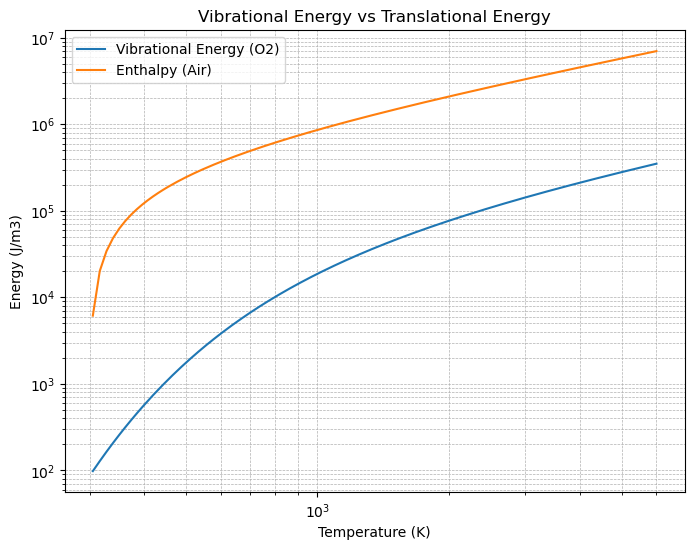

In [127]:
# specific heat capacity of air
cp = 1005.0  # J/(kg·K)
rho = 1.225  # kg/m^3
Tg = 500.0 # K  

xO2 = 0.21
xN2 = 0.79
Ntot = 2.45e25 # m^-3
NO2 = Ntot*xO2
NN2 = Ntot*xN2

theta_v_o2 = 2256.0  # K


kB = 1.38064852e-23 # J/K


# vibratioan energy function 
'''
$$E_{vib} = \frac{n_v \theta_v}{exp(\theta_v/T) - 1}$$
'''
def vibrational_energy(n_v, theta_v, Tv):
    # the units are in J/m3 given that n_v is in m3
    return (n_v * kB* theta_v) / (np.exp(theta_v / Tv) - 1.0)

# range of Tvs
Tv_values = np.linspace(305, 6000, 500)
vib_energy_O2 = vibrational_energy(NO2, theta_v_o2, Tv_values)  # J/m3

# use the same range of Tvs, to calculate the translational energy
trans_energy = rho*cp*(Tv_values-300) # J/m3

# plot the energies
plt.figure(figsize=(8,6))
plt.plot(Tv_values, vib_energy_O2, label='Vibrational Energy (O2)')
plt.plot(Tv_values, trans_energy, label='Enthalpy (Air)')
plt.xlabel('Temperature (K)')
plt.ylabel('Energy (J/m3)')

plt.title('Vibrational Energy vs Translational Energy')

# show minor and major grid
plt.grid(which='both', linestyle='--', linewidth=0.5)


plt.legend()

# log cale in y
plt.yscale('log')
plt.xscale('log')

plt.show()




## Numverial Aperture

Numerical aperture for a focusing setup, with the f-number (N) of the lens, is given by:

$$
NA = \frac{1}{2N} ; NA = \frac{D}{2f}
$$

$$
N = \frac{f}{D}
$$

where $f$ is the focal length of the lens and $D$ is the diameter of the lens.




Focal Spot Size
The focused spot size is related to the NA:
Spot diameter ≈ 1.22 * λ / NA
Where λ is the wavelength of the laser.




In [22]:
## details of laser used
D = 8.0e-3 # m 
f = 40.0e-2 # m
lam = 800.0e-9 # m
M2 = 1.24

# calcualte numerical aperture
NA = D/(2.0*f)

# waist size of the laser
# w0 = 1.22*lam/NA
w0 = M2*1.22*lam/NA    # 1/e2 dia

print("NA: ", NA)
print("w0: ", w0)


## beam spot diameter at focus
bD = 87.0e-6 # m
bD = 48.0e-6 # m
bR = bD/2.0

## numerical aperture from actual beam diameter
bNA = 2*lam/(3.1415*bD)

print("bNA: ", bNA)


NA:  0.01
w0:  0.00012102399999999999
bNA:  0.010610642474401823


In [9]:
3.1415*1.55/2


2.4346625000000004

In [24]:
75000*2

150000

In [27]:
(18/24)*(140000-75000)

48750.0